In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as sp_stats

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
construct_stats = pd.read_csv('constructs_df.csv')

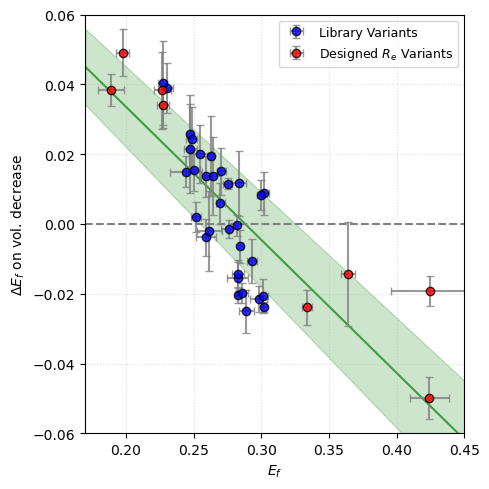

In [4]:
# plot Ef_cell vs Ef_cell_delta with error bars
mask = construct_stats[['Ef_cell', 'Ef_cell_std', 'Ef_cell_delta', 'Ef_cell_delta_std']].notnull().all(axis=1)
plot_df = construct_stats.loc[mask]

x = plot_df['Ef_cell']
y = plot_df['Ef_cell_delta']
xerr = plot_df['Ef_cell_std']
yerr = plot_df['Ef_cell_delta_std']

# Create color array based on construct number
colors = ['red' if construct >= 35 and construct <= 42 else 'blue' for construct in plot_df['construct']]

fig, ax = plt.subplots(figsize=(5, 5))

# Plot points with separate calls for legend
blue_plotted = False
red_plotted = False
for i, (xi, yi, xerri, yerri, color) in enumerate(zip(x, y, xerr, yerr, colors)):
    label = None
    if color == 'blue' and not blue_plotted:
        label = 'Library Variants'
        blue_plotted = True
    elif color == 'red' and not red_plotted:
        label = 'Designed $R_e$ Variants'
        red_plotted = True
    
    ax.errorbar(xi, yi, xerr=xerri, yerr=yerri, fmt='o', color=color, 
                markeredgecolor='black', markeredgewidth=1,
                ecolor='grey', capsize=3, alpha=0.8, label=label)

# Linear regression for line of best fit
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)

# Use the plot x-limits for the line
line_x = np.array([.17, .45])
line_y = slope * line_x + intercept

# Plot line of best fit
ax.plot(line_x, line_y, color='green', linestyle='-', linewidth=1.5, alpha=0.7, zorder=1)

# Calculate 95% confidence interval using prediction interval
n = len(x)
dof = n - 2  # degrees of freedom
t_val = sp_stats.t.ppf(0.975, dof)  # 95% confidence interval

# Calculate standard error of prediction
x_mean = np.mean(x)
sxx = np.sum((x - x_mean)**2)
predict_y = slope * x + intercept
residuals = y - predict_y
s_resid = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval (wider at extremes)
se_line = s_resid * np.sqrt(1/n + (line_x - x_mean)**2 / sxx)
margin = t_val * se_line

# Shade prediction interval
ax.fill_between(line_x, line_y - margin, line_y + margin, 
                color='green', alpha=0.2, zorder=0)

ax.axhline(0, linestyle='--', color='gray')  # dashed horizontal line at y=0

ax.set_xlabel('$E_{f}$')
ax.set_ylabel('Δ$E_{f}$ on vol. decrease')
ax.grid(True, linestyle=':', alpha=0.4)

# Add legend to top right
ax.legend(loc='upper right', frameon=True, fontsize=9)

plt.xlim(.17, .45)
plt.ylim(-.06, .06)

plt.tight_layout()
plt.savefig('Figure_graphs/Fig3/Ef_vs_deltaEf.svg')